In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.python.keras as krs
from keras.layers import LSTM, Dropout, Dense
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler


2022-10-16 00:24:33.137942: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-16 00:24:33.585210: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-16 00:24:33.585234: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-16 00:24:33.652373: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-16 00:24:34.864014: W tensorflow/stream_executor/platform/de

In [2]:
_df = pd.read_csv("Data/wig20_d.csv")
# df = pd.read_csv("Data/mwig40_d.csv")
# df = pd.read_csv("Data/swig80_d.csv")

_df.drop(range(1000), inplace=True)
_df.reset_index(inplace=True, drop=True)
_df.head()

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen
0,1997-02-06,1717.2,1779.8,1717.2,1779.8,4435886.0
1,1997-02-07,1778.2,1808.7,1778.2,1799.0,5448243.0
2,1997-02-10,1797.4,1797.4,1780.3,1783.3,6513315.0
3,1997-02-11,1803.3,1832.2,1803.3,1832.0,5146340.0
4,1997-02-12,1824.6,1824.6,1804.9,1810.2,5748398.0


In [3]:
_df.head()

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen
0,1997-02-06,1717.2,1779.8,1717.2,1779.8,4435886.0
1,1997-02-07,1778.2,1808.7,1778.2,1799.0,5448243.0
2,1997-02-10,1797.4,1797.4,1780.3,1783.3,6513315.0
3,1997-02-11,1803.3,1832.2,1803.3,1832.0,5146340.0
4,1997-02-12,1824.6,1824.6,1804.9,1810.2,5748398.0


In [4]:
_data_len = len(_df.index)
_train_set_ratio, _test_set_ratio, _validation_set_ratio = .8, .1, .1
scaler = MinMaxScaler(feature_range=(0,1))

_train_set_len = int(_data_len * _train_set_ratio)
_test_set_len = int(_data_len * _test_set_ratio)
_validation_set_len = int(_data_len * _validation_set_ratio)

_train_set_end = _train_set_len
_test_set_end = _train_set_end + _test_set_len
_validation_set_end = _test_set_end + _validation_set_len


colnames = _df.columns.to_numpy()
col_len = 5

_data = _df.to_numpy()[:, 1:col_len]
#_data = _data.flatten().reshape((-1, 1))
#_data = _df.to_numpy().transpose()[1:5, :]
_data = scaler.fit_transform(_data)


#train_set, test_set, validation_set = _df.iloc[:_train_set_end, :], _df.iloc[_train_set_end:_test_set_end, :], _df.iloc[_test_set_end:_validation_set_end, :]
train_set, test_set, validation_set = _data[:_train_set_end, :], _data[_train_set_end:_test_set_end, :], _data[_test_set_end:_validation_set_end, :]


In [5]:
colnames

array(['Data', 'Otwarcie', 'Najwyzszy', 'Najnizszy', 'Zamkniecie',
       'Wolumen'], dtype=object)

In [6]:
train_set[:, :10]

array([[0.24675461, 0.26440479, 0.25373683, 0.27438683],
       [0.26746804, 0.27424346, 0.27448753, 0.28090288],
       [0.27398767, 0.27039651, 0.27520189, 0.27557465],
       ...,
       [0.46054432, 0.46188283, 0.46512182, 0.47124962],
       [0.46464965, 0.46812306, 0.46929237, 0.47715819],
       [0.47197745, 0.47321261, 0.47799065, 0.48053839]])

In [7]:
test_set[:, :10]

array([[0.47437138, 0.4740535 , 0.47738854, 0.48183481],
       [0.47701319, 0.49488832, 0.48440976, 0.50396563],
       [0.50061631, 0.50333459, 0.50617078, 0.5092158 ],
       ...,
       [0.14132328, 0.15874297, 0.14135308, 0.16905419],
       [0.17372791, 0.18540269, 0.17190764, 0.17549897],
       [0.15983293, 0.15687056, 0.14607472, 0.14734081]])

In [8]:
validation_set[:, :10]

array([[0.15579891, 0.15996514, 0.15404503, 0.16280625],
       [0.16884158, 0.1711213 , 0.15033031, 0.15968737],
       [0.14975127, 0.16672284, 0.14954451, 0.17671734],
       ...,
       [0.14393793, 0.14202745, 0.14544539, 0.14725936],
       [0.13913649, 0.13520506, 0.13880857, 0.13853056],
       [0.13145894, 0.13714216, 0.1324643 , 0.1393281 ]])

In [9]:
train_set.shape

(5143, 4)

In [10]:
def batches_create(data_array: np.array):
    _x_train = np.array([data_array[i:i+60, :].astype("float32") for i in range(data_array.shape[0]-60-1)])
    _y_train = np.array([data_array[i+60, :].astype("float32") for i in range(data_array.shape[0]-60-1)])
    print(_x_train.shape)
    print(_y_train.shape)
    #_x_train, _y_train = np.reshape(_x_train, (_x_train.shape[0], _x_train.shape[1], 1)), _y_train
    return _x_train, _y_train


In [11]:
X_train, y_train = batches_create(train_set)
X_test, y_test = batches_create(test_set)
X_validation, y_validation = batches_create(validation_set)


(5082, 60, 4)
(5082, 4)
(581, 60, 4)
(581, 4)
(581, 60, 4)
(581, 4)


In [12]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=y_train.shape[1]))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=2, batch_size=32)

Epoch 1/2


2022-10-16 00:24:36.375762: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-16 00:24:36.376188: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-16 00:24:36.376218: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (banjaro): /proc/driver/nvidia/version does not exist
2022-10-16 00:24:36.377074: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


159/159 [==============================] - 21s 85ms/step - loss: 0.0098
Epoch 2/2
159/159 [==============================] - 14s 91ms/step - loss: 0.0042


In [13]:
#model = krs.models.load_model("Models/model_lstm_1")

In [14]:
X_test.shape

(581, 60, 4)

In [15]:
output_col_num = 0

In [16]:
prediction_test = model.predict(np.array(X_test))

19/19 [==============================] - 2s 23ms/step


In [17]:
prediction_test

array([[0.5300613 , 0.53536516, 0.5287077 , 0.53517973],
       [0.5298154 , 0.5350776 , 0.52840996, 0.53486466],
       [0.5292444 , 0.5344597 , 0.5277738 , 0.5342099 ],
       ...,
       [0.28437257, 0.2860083 , 0.28235304, 0.28839633],
       [0.27071008, 0.2720526 , 0.26830202, 0.27445158],
       [0.25660565, 0.25768125, 0.25387216, 0.2601478 ]], dtype=float32)

In [18]:
y_t = scaler.inverse_transform(prediction_test)[:, output_col_num]

In [19]:
#scaler.inverse_transform(prediction_test)

In [20]:
y_t

array([2551.524 , 2550.7998, 2549.1184, 2546.5479, 2543.351 , 2539.867 ,
       2536.4548, 2533.4082, 2530.9224, 2529.093 , 2527.8608, 2526.9602,
       2526.0115, 2524.6665, 2522.6958, 2519.9407, 2516.3447, 2511.993 ,
       2507.0044, 2501.5415, 2495.8142, 2490.084 , 2484.5876, 2479.6216,
       2475.4888, 2472.4097, 2470.4995, 2469.751 , 2470.1174, 2471.5337,
       2473.8628, 2476.9016, 2480.6194, 2485.067 , 2490.3289, 2496.4258,
       2503.2292, 2510.5625, 2518.2688, 2526.1838, 2534.2742, 2542.606 ,
       2551.2393, 2560.1829, 2569.4412, 2579.0398, 2588.9236, 2598.9038,
       2608.729 , 2618.1458, 2626.842 , 2634.5205, 2640.9055, 2645.7034,
       2648.6592, 2649.3865, 2647.6404, 2643.3242, 2636.414 , 2627.121 ,
       2615.8535, 2603.1697, 2589.6836, 2575.9092, 2562.2336, 2548.946 ,
       2536.2522, 2524.2893, 2513.1833, 2503.0469, 2493.9817, 2485.9307,
       2478.6353, 2471.7144, 2464.8262, 2457.8037, 2450.6252, 2443.3345,
       2436.0164, 2428.9033, 2422.2192, 2416.0776, 

In [21]:
np.array([X_test[0]])

array([[[0.47437137, 0.4740535 , 0.47738853, 0.4818348 ],
        [0.4770132 , 0.4948883 , 0.48440975, 0.5039656 ],
        [0.5006163 , 0.5033346 , 0.5061708 , 0.5092158 ],
        [0.503781  , 0.52117693, 0.50984126, 0.52943254],
        [0.5211939 , 0.51823896, 0.5130015 , 0.51798534],
        [0.515041  , 0.5222664 , 0.5211657 , 0.52714515],
        [0.519435  , 0.520765  , 0.520567  , 0.5243249 ],
        [0.5167965 , 0.5193999 , 0.52304006, 0.52818024],
        [0.517109  , 0.5183445 , 0.52283937, 0.5253973 ],
        [0.51971   , 0.52686226, 0.52453005, 0.5247288 ],
        [0.5166777 , 0.51922286, 0.52216923, 0.5230149 ],
        [0.5165792 , 0.519342  , 0.5139472 , 0.5160203 ],
        [0.5087183 , 0.5094625 , 0.51316476, 0.513234  ],
        [0.5089764 , 0.51783043, 0.5164305 , 0.5233678 ],
        [0.5187287 , 0.52187145, 0.5200567 , 0.52080214],
        [0.5151904 , 0.5171632 , 0.51983905, 0.51886094],
        [0.51329565, 0.5133605 , 0.51945466, 0.5213282 ],
        [0.514

In [22]:
X_test.shape

(581, 60, 4)

In [23]:
y_test

array([[0.48829353, 0.48870936, 0.48921305, 0.48863932],
       [0.48290125, 0.49110264, 0.4896859 , 0.49974376],
       [0.49156353, 0.49949104, 0.4966799 , 0.50797707],
       ...,
       [0.1476256 , 0.15743227, 0.13792412, 0.145929  ],
       [0.14132328, 0.15874296, 0.14135309, 0.1690542 ],
       [0.1737279 , 0.18540269, 0.17190763, 0.17549898]], dtype=float32)

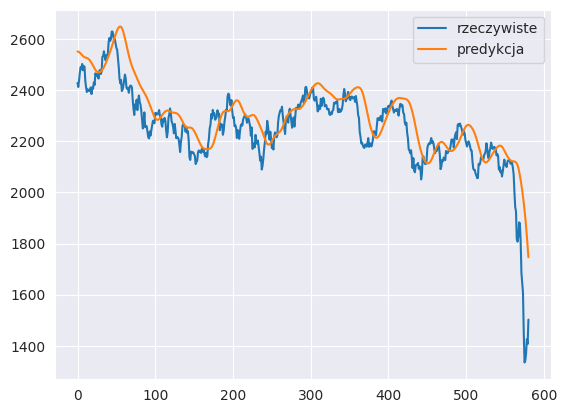

In [24]:
plt.plot(range(len(y_test)), scaler.inverse_transform(y_test)[:, output_col_num], label="rzeczywiste")
plt.plot(range(len(y_test)), y_t, label="predykcja")
plt.legend()

In [25]:
prediction_validation = model.predict(X_validation)

19/19 [==============================] - 1s 34ms/step


In [26]:
prediction_validation

array([[0.25691193, 0.26094505, 0.2636266 , 0.26505825],
       [0.25987774, 0.2638898 , 0.26647383, 0.26785132],
       [0.26246598, 0.26644623, 0.2689204 , 0.27026752],
       ...,
       [0.15932049, 0.16132596, 0.16290148, 0.16535908],
       [0.15697615, 0.1589567 , 0.16050021, 0.16289026],
       [0.15458776, 0.15654247, 0.15806106, 0.16040437]], dtype=float32)

In [27]:
y_v = scaler.inverse_transform(prediction_validation)[:, output_col_num]

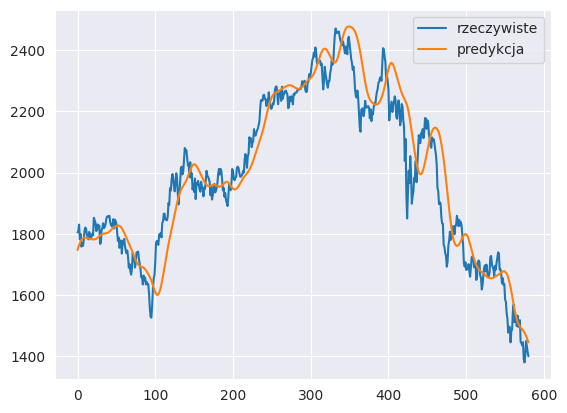

In [28]:
plt.plot(range(len(y_validation)), scaler.inverse_transform(y_validation)[:, output_col_num], label="rzeczywiste")
plt.plot(range(len(y_validation)), y_v, label="predykcja")
plt.legend()

In [29]:
deltas_test = y_t - scaler.inverse_transform(y_test)[:, output_col_num]

(array([ 2.,  2.,  1.,  6., 20., 23., 27., 28., 38., 59., 52., 42., 43.,
        34., 34., 41., 21., 29., 15., 19.,  6.,  3., 13.,  5.,  2.,  3.,
         1.,  1.,  0.,  2.,  0.,  0.,  1.,  0.,  1.,  2.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([-136.85791016, -122.17345428, -107.48899841,  -92.80454254,
         -78.12008667,  -63.4356308 ,  -48.75117493,  -34.06672287,
         -19.38226509,   -4.69781017,    9.9866457 ,   24.67110062,
          39.35555649,   54.04001236,   68.72446442,   83.40892029,
          98.09337616,  112.77783203,  127.4622879 ,  142.14674377,
         156.83120728,  171.51565552,  186.20011902,  200.88456726,
         215.56903076,  230.253479  ,  244.93792725,  259.62237549,
         274.30685425,  288.99130249,  303.67575073,  318.36019897,
         333.04467773,  347.72912598,  362.41357422,  377.09802246,
         391.78250122,  406.46694946,  421.15139771,  435.83584595,
         450.52032471,  465.20477295

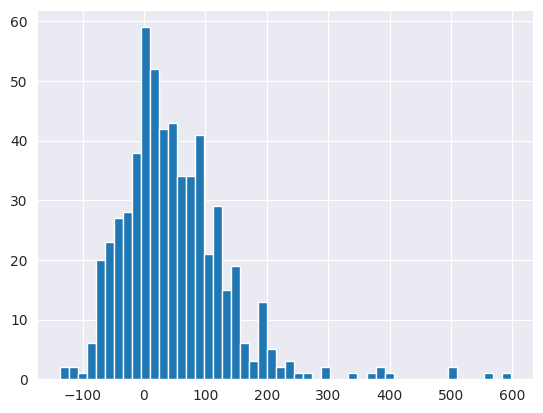

In [30]:
plt.hist(deltas_test, bins=50)

In [31]:
deltas_validation = y_v - scaler.inverse_transform(y_validation)[:, output_col_num]

(array([ 4.,  6.,  4.,  3.,  6.,  4.,  4., 14., 12., 10., 22., 26., 25.,
        21., 33., 41., 26., 40., 35., 35., 42., 23., 25., 11., 16., 15.,
        12., 10.,  7.,  8.,  5.,  2.,  3.,  5.,  4.,  3.,  4.,  3.,  2.,
         3.,  3.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-1.90111694e+02, -1.78932938e+02, -1.67754181e+02, -1.56575424e+02,
        -1.45396667e+02, -1.34217911e+02, -1.23039154e+02, -1.11860390e+02,
        -1.00681633e+02, -8.95028763e+01, -7.83241196e+01, -6.71453629e+01,
        -5.59666061e+01, -4.47878494e+01, -3.36090927e+01, -2.24303341e+01,
        -1.12515774e+01, -7.28198215e-02,  1.11059380e+01,  2.22846947e+01,
         3.34634514e+01,  4.46422081e+01,  5.58209686e+01,  6.69997253e+01,
         7.81784821e+01,  8.93572388e+01,  1.00535995e+02,  1.11714752e+02,
         1.22893509e+02,  1.34072266e+02,  1.45251022e+02,  1.56429779e+02,
         1.67608536e+02,  1.78787292e+02,  1.89966049e+02,  2.01144806e+02,
         2.12323563e+02,  2.2350

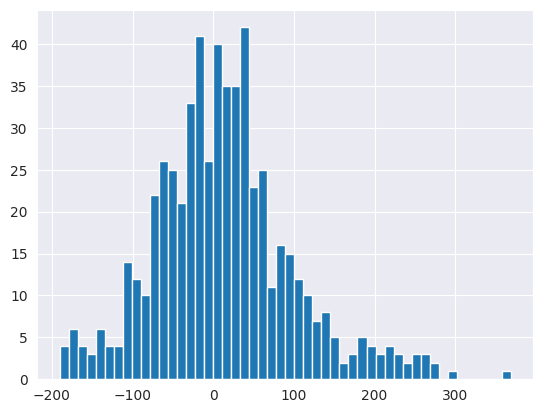

In [32]:
plt.hist(deltas_validation, bins=50)

In [33]:
#model.save("Models/tmp")